# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.
* [Step -1](#step-1): Import Dependencies
* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>


## Step -1: Import Dependencies

In [16]:
import os
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets
import numpy as np

import cv2                
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
use_cuda = torch.cuda.is_available()

## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [17]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


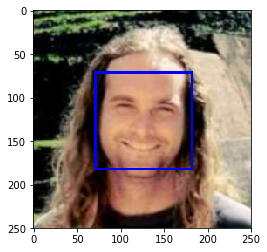

In [18]:
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [19]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

###  (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

    face_detector algorithm detected:
      - 98 faces in the sample human dataset and correctly classified 98.00% of images.
      - 16 faces in the sample dog dataset and misclassified 16.00% of images.

In [20]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
def findFaces(humanImages, dogImages):
    facesInHumanArr = 0
    facesInDogArr = 0
    for image in humanImages:
        if face_detector(image):
            facesInHumanArr = facesInHumanArr + 1
    for image in dogImages:
        if face_detector(image):
            facesInDogArr = facesInDogArr + 1
    return (facesInHumanArr, facesInDogArr)

facesInHumanImages, facesInDogImages = findFaces(human_files_short, dog_files_short)

print('face_detector algorithm detected:')
print('  - {} faces in the sample human dataset and correctly classified {:.2f}% of images.'.format(facesInHumanImages, facesInHumanImages/len(human_files_short)*100))
print('  - {} faces in the sample dog dataset and misclassified {:.2f}% of images.'.format(facesInDogImages, facesInDogImages/len(dog_files_short)*100))

face_detector algorithm detected:
  - 98 faces in the sample human dataset and correctly classified 98.00% of images.
  - 16 faces in the sample dog dataset and misclassified 16.00% of images.


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [25]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    print('CUDA available. Move model to GPU.')
    VGG16 = VGG16.cuda().type(torch.FloatTensor)

CUDA available. Move model to GPU.


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [26]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    # Define transforms for the image
    data_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.485, 0.456, 0.406),
                                                              (0.229, 0.224, 0.225))])
    # Load and pre-process the image from the given img_path
    image = Image.open(img_path)
    # Convert 3-dimensional Tensor to 4-dimensional Tensor
    image = data_transform(image)[:3,:,:].unsqueeze(0).float()
    
    # Pass the image through the VGG16 model
    VGG16.eval()
    if use_cuda:
        # Fixes Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) error
        image = image.cuda()
        output = VGG16(image).cpu().detach().numpy()
    else:
        output = VGG16(image).detach().numpy()
        
    # Obtain the index of the predicted class for that image 
    index = output.argmax()

    return index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [27]:
### Returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    class_index = VGG16_predict(img_path)
    return class_index >= 151 and class_index <= 268

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

    dog_detector algorithm detected:
      - 0 dog(s) in the sample human dataset and misclassified 0.00% of images.
      - 100 dog(s) in the sample dog dataset and correctly classified 100.00% of images.


In [28]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
def findDog(humanImages, dogImages):
    dogsInHumanArr = 0
    dogsInDogArr = 0
    for image in humanImages:
        if dog_detector(image):
            dogsInHumanArr = dogsInHumanArr + 1
    for image in dogImages:
        if dog_detector(image):
            dogsInDogArr = dogsInDogArr + 1
    return (dogsInHumanArr, dogsInDogArr)

dogsInHumanImages, dogsInDogImages = findDog(human_files_short, dog_files_short)

print('dog_detector algorithm detected:')
print('  - {} dog(s) in the sample human dataset and misclassified {:.2f}% of images.'.format(dogsInHumanImages, dogsInHumanImages/len(human_files_short)*100))
print('  - {} dog(s) in the sample dog dataset and correctly classified {:.2f}% of images.'.format(dogsInDogImages, dogsInDogImages/len(dog_files_short)*100))

dog_detector algorithm detected:
  - 0 dog(s) in the sample human dataset and misclassified 0.00% of images.
  - 100 dog(s) in the sample dog dataset and correctly classified 100.00% of images.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [56]:
# Define directories for training, validation, and test data
data_dir = './dogImages'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# Get current working dir
print(os.getcwd())
# Get current data_dir content
print(os.listdir(data_dir))

# Define your transforms for the training, validation, and test sets
data_transforms = {
    'train' : transforms.Compose([transforms.Resize(256),
                                  transforms.RandomRotation(30),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomResizedCrop(224),                                   
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406),
                                                       (0.229, 0.224, 0.225))]),                                                                                                   
                                                                                                                         
    'valid' : transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406),
                                                       (0.229, 0.224, 0.225))]),
    'test' : transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406),
                                                      (0.229, 0.224, 0.225))])
}

# Load the datasets with ImageFolder
image_datasets = {
    x: datasets.ImageFolder(globals()[x + '_dir'], transform = data_transforms[x])
    for x in list(data_transforms.keys())
}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 64, shuffle = True)
    for x in list(data_transforms.keys())
} 

# Check if images are loaded correctly
print('Number of training images: ', len(image_datasets['train']))
print('Number of validation images: ', len(image_datasets['valid']))
print('Number of testing images: ', len(image_datasets['valid']))


/home/ubuntu/DEV/project-dog-classification
['train', 'valid', 'test']
Number of training images:  6680
Number of validation images:  835
Number of testing images:  835


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- First, it resizes the images to 256x256 pixels, then it center crops them to 224x224 pixels. This minimizes the distortion and minimizes the chance of cropping the meaningful data out of the image. I have run a small number of experiments, and it seems to get better classification results using a 224x224 image as an input. I have choose to use 224x224 as that is the minimum sieze expectebe by a pre-trained model. Besides, it takes a shorter period of time to train.
- Moreover, during preprocessing I've implemented random rotation of 30 degrees and random horizontal flip for the training data set. This lets network to train from more unpredictable image outputs and possibly creates better classification results.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [97]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        
        ## Define maxpooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        ## Define batch normalizations
        self.bn32 = nn.BatchNorm2d(32)
        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        
        ## Define dropout and fully connected linear layer
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, 133)
    
    def forward(self, x):
        ## Define forward behavior
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.bn32(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.bn64(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.bn64(x)

        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.bn128(x)
        
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = self.bn256(x)

        x = x.view(-1, 256)
        
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move model to GPU if CUDA is available
if use_cuda:
    print('CUDA available. Move model to GPU.')
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=256, out_features=133, bias=True)
)
CUDA available. Move model to GPU.


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

- Used the 5 convolution layers in total. These layers increase in size gradually except the 3rd convolutional layer, which stays the same in size. All the layers have a padding of 1. For the 2nd, 4th and 5th layer, that doubled in size, I have applied stride of 2, which will lead to downsizing of an input image by 2.
- After each convolution layer applied ReLu activation function. Followed by Max Pooling of 2x2 and Batch Normalization.
- Dropout layer with the probability of 0.5 is applied at the end, to reduce potential overfitting.
- Finally, the output is fed to a fully connected layer which outputs 133 classes.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [98]:
# Define parameters
n_epochs = 20
learning_rate = 0.01
loaders_scratch = dataloaders
model_path = 'model_scratch.pt'

### Specify CrossEntropyLoss function
criterion_scratch = nn.CrossEntropyLoss()

### Define Adam optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=learning_rate)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [23]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing images to the model
            outputs = model(data)
            # calculate the loss
            loss = criterion(outputs, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            ## update the average validation loss
            with torch.no_grad():
                output = model(data)
                loss = criterion(output, target)
                valid_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
              epoch, 
              train_loss
              ))
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased: {:.6f} ==> {:.6f}. Saving model to: {:}'.format(
                  valid_loss_min,
                  valid_loss,
                  save_path
                  ))
            
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        else:
            print('Validation loss did not decrease.')
                  
        print('======================================================')
            
    # return trained model
    return model

In [ ]:
# train the model
model_scratch = train(n_epochs, 
                      loaders_scratch, 
                      model_scratch, 
                      optimizer_scratch, 
                      criterion_scratch, 
                      use_cuda, 
                      model_path)

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load(model_path))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [10]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))


In [ ]:
#  calculate and print the test loss and accuracy
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

In [5]:
# Define directories for training, validation, and test data
data_dir = './dogImages'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# Get current working dir
print(os.getcwd())
# Get current data_dir content
print(os.listdir(data_dir))

# Define your transforms for the training, validation, and test sets
data_transforms = {
    'train' : transforms.Compose([transforms.Resize(256),
                                  transforms.RandomRotation(30),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomResizedCrop(224),                                   
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406),
                                                       (0.229, 0.224, 0.225))]),                                                                                                   
                                                                                                                         
    'valid' : transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406),
                                                       (0.229, 0.224, 0.225))]),
    'test' : transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406),
                                                      (0.229, 0.224, 0.225))])
}

# Load the datasets with ImageFolder
image_datasets = {
    x: datasets.ImageFolder(globals()[x + '_dir'], transform = data_transforms[x])
    for x in list(data_transforms.keys())
}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 64, shuffle = True)
    for x in list(data_transforms.keys())
} 

# Check if images are loaded correctly
print('Number of training images: ', len(image_datasets['train']))
print('Number of validation images: ', len(image_datasets['valid']))
print('Number of testing images: ', len(image_datasets['valid']))


/home/ubuntu/DEV/project-dog-classification
['train', 'valid', 'test']
Number of training images:  6680
Number of validation images:  835
Number of testing images:  835


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [6]:
## TODO: Specify model architecture 
def get_model_transfer():
    model = models.densenet161(pretrained=True)
    print(model)
    # Freeze training for all "features" layers
    for param in model.parameters():
        param.requires_grad = False
        
    classifier_in_features = model.classifier.in_features
    model.classifier = nn.Linear(classifier_in_features, 133)
    
    return model

# instantiate the CNN
model_transfer = get_model_transfer()
print(model_transfer)

# move model to GPU if CUDA is available
if use_cuda:
    print('CUDA available. Move model to GPU.')
    model_transfer.cuda()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [7]:
# Define parameters
n_epochs = 20
learning_rate = 0.01
loaders_transfer = dataloaders
final_model_path = 'model_transfer.pt'

### Specify CrossEntropyLoss function
criterion_transfer = nn.CrossEntropyLoss()

### Define Adam optimizer
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=learning_rate)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [29]:
# train the model
# model_transfer = train(n_epochs, 
#                        loaders_transfer, 
#                        model_transfer, 
#                        optimizer_transfer, 
#                        criterion_transfer, 
#                        use_cuda, 
#                        final_model_path)

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load(final_model_path))


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [30]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.405562

Test Accuracy: 80% (674/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [41]:
### A function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    # Define transforms for the image
    data_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.485, 0.456, 0.406),
                                                              (0.229, 0.224, 0.225))])
    # Load and pre-process the image from the given img_path
    image = Image.open(img_path)
    # Convert 3-dimensional Tensor to 4-dimensional Tensor
    image = data_transform(image)[:3,:,:].unsqueeze(0).float()
    
    # Pass the image through the VGG16 model
    model_transfer.eval()
    if use_cuda:
        # Fixes Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor)
        image = image.cuda()
        output = model_transfer(image).cpu().detach().numpy()
    else:
        output = model_transfer(image).detach().numpy()
        
    # Obtain the index of the predicted class for that image 
    index = output.argmax()
    
    return class_names[index]

German shepherd dog


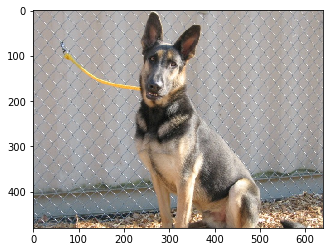

In [43]:
print(predict_breed_transfer(dog_files_short[55]))
plt.imshow(plt.imread(dog_files_short[55]))

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)